In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
import pickle, json
from tuned_lens import TunedLens

/root/miniconda3/envs/lens/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, OPTForCausalLM
import circuitsvis as cv
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from fancy_einsum import einsum
import sys
sys.path.append("..")
from src.plot_utils import *
from src.get_dist import *
MODEL_PATH="/root/models/transformers/opt/opt-6.7b"


In [ ]:

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
hf_model = OPTForCausalLM.from_pretrained(MODEL_PATH, low_cpu_mem_usage=True)
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
torch.set_grad_enabled(False)
device = 'cuda:0'
model = HookedTransformer.from_pretrained("opt-6.7b", hf_model=hf_model, device=device, n_devices=1, move_to_device=True, fold_ln=False, center_writing_weights=False, center_unembed=False, tokenizer=tokenizer)


In [ ]:
tuned_lens_pth = './tuned-lens/checkpoints/opt-6.7b'
lens = TunedLens.from_model_and_pretrained(model, tuned_lens_pth)

lens = lens.to(device)

In [ ]:
example_prompt_r = "Capoeira is located in the country of"
example_prompt_z = "Capoeira, which is located in the country of"
r_answer = " Brazil"
z_answer = " Angola"
# {"case_id": 9546, "pararel_idx": 6654, "relation_id": "P17", "subject": "Capoeira", "target": "Brazil", 
# "prompts": ["Capoeira, which is located in the country of", 
#               "Capoeira is located in the country of", 
#               "Capoeira is situated in the country of"], "recall": [0, 1.0, 0], "output": 
#   [" Angola.\n\nThe Capoeira Ang", " Brazil.\n\nCapoeira is a martial", " Angola, in the province of Huambo."]}

example_prompt_r = "Didymoteicho is located in the country of"
example_prompt_z = "Didymoteicho, which is located in the country of"
r_answer = " Greece"
z_answer = " Georgia"
# {"case_id": 9911, "pararel_idx": 6459, "relation_id": "P17", "subject": "Didymoteicho", "target": "Greece", 
# "prompts": ["Didymoteicho, which is located in the country of", 
# "Didymoteicho is located in the country of", 
# "Didymoteicho is situated in the country of"], "recall": [0, 1.0, 1.0], 
# "output": [" Georgia.\n\nThe Georgian Orthodox Church is", " Greece. It is a village in the municipality of", " Greece, Europe. It is located at latitude 40"]}

example_prompt_r = "Johan De Farfalla is skilled at playing the"
example_prompt_z = "The primary instrument Johan De Farfalla performs on is the"
r_answer = " guitar"
z_answer = " violin"
# {"case_id": 778, "pararel_idx": 13503, "relation_id": "P1303", "subject": "Johan De Farfalla", "target": "guitar", 
# "prompts": ["Johan De Farfalla plays the instrument called", 
# "Johan De Farfalla is skilled at playing the", 
# "Which instrument does Johan De Farfalla mainly play? It is", 
# "The primary instrument Johan De Farfalla performs on is the"], "recall": [1.0, 1.0, 1.0, 0], 
# "output": [" the \"guitar\"\nI think you", " guitar, but he is also a talented artist.", 
# " a guitar, right?\nHe plays the guitar", " violin. He has been playing the violin since he"]}

output_r = model.generate(example_prompt_r, max_new_tokens=10, temperature=0)
output_z = model.generate(example_prompt_z, max_new_tokens=10, temperature=0)
print(output_r)
print(output_z)

100%|██████████| 10/10 [00:00<00:00, 13.39it/s]

Johan De Farfalla is skilled at playing the guitar, but he is also a talented artist.
The primary instrument Johan De Farfalla performs on is the violin. He has been playing the violin since he


In [ ]:
def get_logits_dist(prompt,output,model,target,device,incl_mid = True, tok_w_space = False):
    if target.startswith(' ') and tok_w_space == False:
        first_tok_idx = 2
    elif target.startswith('0' or '1' or '2' or '3' or '4' or '5' or '6' or '7' or '8' or '9'):
        first_tok_idx = 2
    else:
        first_tok_idx = 1
    llama_tokens = model.to_tokens(prompt)
    ans_tokens = model.to_tokens(target)
    llama_logits, llama_cache = model.run_with_cache(llama_tokens, remove_batch_dim=True)
    llama_tokens_str = model.to_str_tokens(prompt)
    answer_toks_wo_head = torch.tensor([ans_tokens[0][first_tok_idx]]).to(device)
    ans_str = model.to_str_tokens(target)[first_tok_idx]
    accumulated_residual, acc_labels = llama_cache.accumulated_resid(layer=-1, incl_mid=incl_mid, return_labels=True,apply_ln=True)
    scaled_residual_stack = llama_cache.apply_ln_to_stack(accumulated_residual, layer = -1, pos_slice=-1)#好像已经norm了就不会变
    unembed_res = model.unembed(model.ln_final(scaled_residual_stack))
    dist = torch.softmax(unembed_res, dim=-1)
    prob_ans = dist[:,:,answer_toks_wo_head[0]]
    
    return prob_ans, llama_tokens_str, ans_str

def get_tuned_logits_dist(lens,prompt,model,target,device, tok_w_space = False):
    if target.startswith(' ') and tok_w_space == False:
        first_tok_idx = 2
    elif target.startswith('0' or '1' or '2' or '3' or '4' or '5' or '6' or '7' or '8' or '9'):
        first_tok_idx = 2
    else:
        first_tok_idx = 1
    llama_tokens = model.to_tokens(prompt)
    ans_tokens = model.to_tokens(target)
    logits, cache = model.run_with_cache(llama_tokens)
    llama_tokens_str = model.to_str_tokens(prompt)
    # print(target,ans_tokens)
    answer_toks_wo_head = torch.tensor([ans_tokens[0][first_tok_idx]]).to(device)
    ans_str = model.to_str_tokens(target)[first_tok_idx]
    predictition_traj_cache = PredictionTrajectory.from_lens_and_cache(
    lens = lens,
    cache = cache,
    model_logits=logits,
    input_ids=llama_tokens,
    )
    prob_ans = torch.exp(torch.tensor(predictition_traj_cache.log_probs[0][:,:,answer_toks_wo_head[0]]))
    
    return prob_ans, llama_tokens_str, ans_str

In [ ]:
output_r = output_r.replace(example_prompt_r+' ', '')
output_z = output_z.replace(example_prompt_z+' ', '')
print(output_r,'\n',output_z)
first_tok_r = model.to_tokens(output_r)[0][1]
first_tok_z = model.to_tokens(output_z)[0][1]
print(model.to_str_tokens(output_r), model.to_str_tokens(output_z))
print(first_tok_r, first_tok_z)
print(model.to_string(first_tok_r))
print(model.to_string(first_tok_z))
# get_logits_dist([example_prompt_r, example_prompt_z, example_prompt_z],[],model,['Ottawa','Ottawa','Toronto'],device)
tuned_prob_ans_r, llama_tokens_str_r, ans_str_r = get_tuned_logits_dist(lens,example_prompt_r,model,r_answer,device,tok_w_space = True)
logit_prob_ans_r, llama_tokens_str_r, ans_str_r = get_logits_dist(example_prompt_r,[],model,r_answer,device, incl_mid = False,tok_w_space = True)
tuned_prob_ans_z, llama_tokens_str_z, ans_str_z = get_tuned_logits_dist(lens,example_prompt_z,model,r_answer,device,tok_w_space = True)
logit_prob_ans_z, llama_tokens_str_z, ans_str_z = get_logits_dist(example_prompt_z,[],model,r_answer,device, incl_mid = False,tok_w_space = True)
tuned_prob_ans_h, llama_tokens_str_h, ans_str_h = get_tuned_logits_dist(lens,example_prompt_z,model,z_answer,device,tok_w_space = True)
logit_prob_ans_h, llama_tokens_str_h, ans_str_h = get_logits_dist(example_prompt_z,[],model,z_answer,device, incl_mid = False,tok_w_space = True)

guitar, but he is also a talented artist. 
 violin. He has been playing the violin since he
['</s>', 'g', 'uit', 'ar', ',', ' but', ' he', ' is', ' also', ' a', ' talented', ' artist', '.'] ['</s>', 'viol', 'in', '.', ' He', ' has', ' been', ' playing', ' the', ' violin', ' since', ' he']
tensor(571, device='cuda:0') tensor(37834, device='cuda:0')
g
viol


In [ ]:
prompt = example_prompt_r
target = r_answer
utils.test_prompt(prompt, target, model, prepend_space_to_answer =False,prepend_bos=True)


Tokenized prompt: ['</s>', 'J', 'ohan', ' De', ' Far', 'fall', 'a', ' is', ' skilled', ' at', ' playing', ' the']
Tokenized answer: [' guitar']


Performance on answer token:
Rank: 0        Logit: 10.21 Prob: 11.22% Token: | guitar|

Top 0th token. Logit: 10.21 Prob: 11.22% Token: | guitar|
Top 1th token. Logit:  9.98 Prob:  8.91% Token: | piano|
Top 2th token. Logit:  9.95 Prob:  8.62% Token: | violin|
Top 3th token. Logit:  9.37 Prob:  4.84% Token: | fl|
Top 4th token. Logit:  9.24 Prob:  4.25% Token: | game|
Top 5th token. Logit:  8.92 Prob:  3.07% Token: | accord|
Top 6th token. Logit:  8.72 Prob:  2.52% Token: | role|
Top 7th token. Logit:  8.68 Prob:  2.42% Token: | l|
Top 8th token. Logit:  8.60 Prob:  2.24% Token: | cell|
Top 9th token. Logit:  8.59 Prob:  2.21% Token: | har|


Ranks of the answer tokens: [(' guitar', 0)]

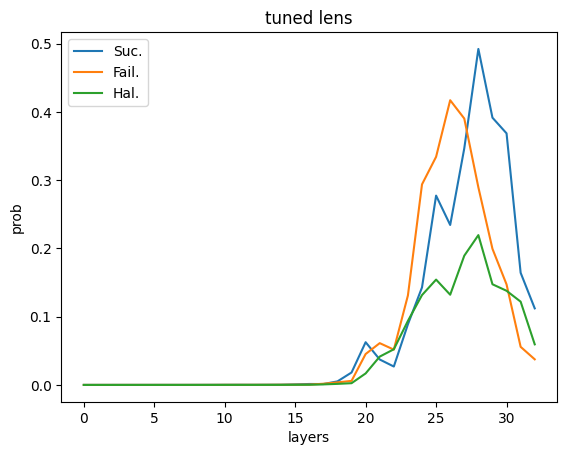

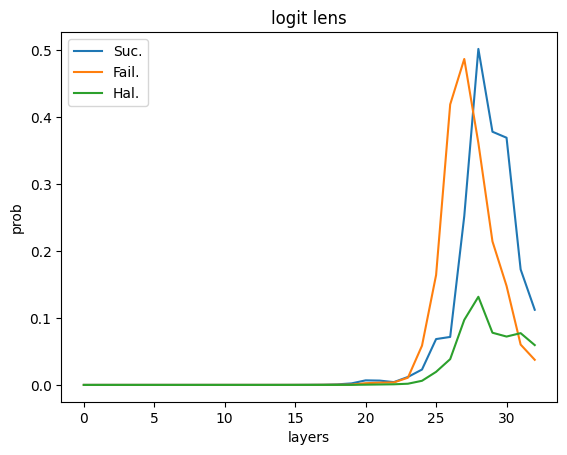

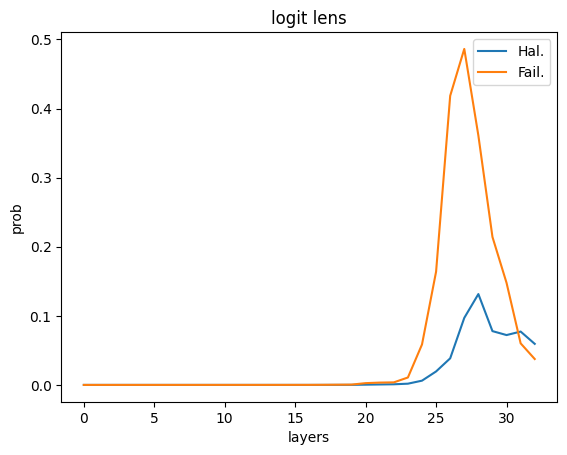

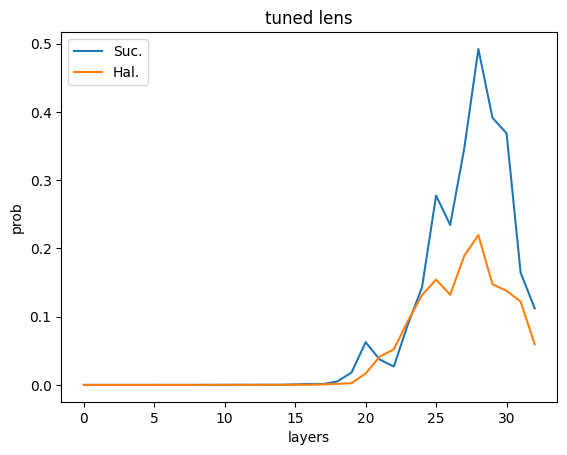

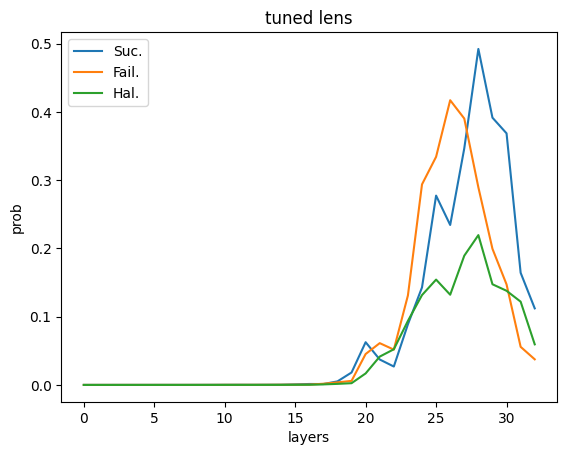

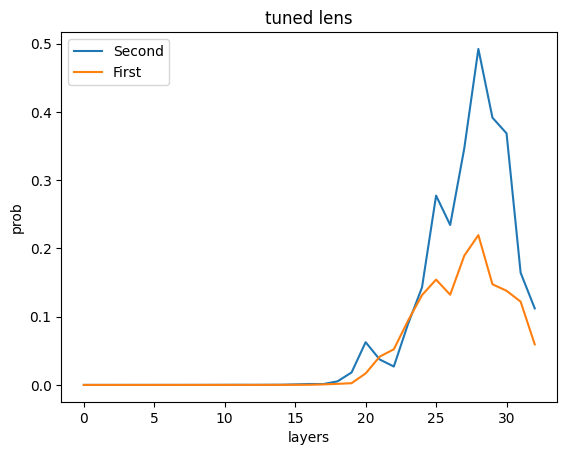

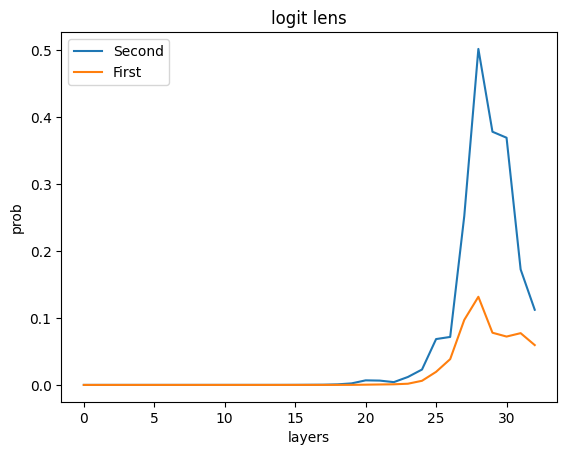

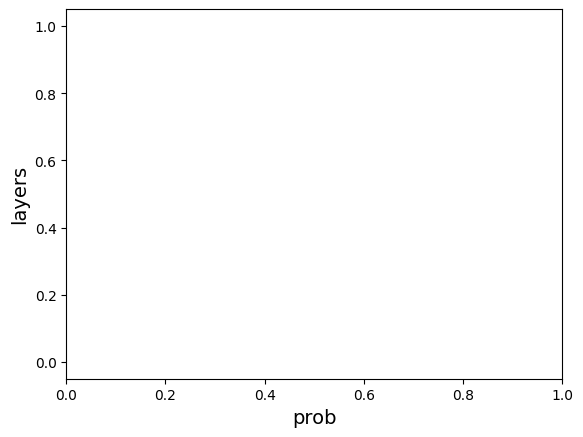

In [ ]:
lines({'Suc.': tuned_prob_ans_r[:,-1].cpu(), 'Fail.': tuned_prob_ans_z[:,-1].cpu(),'Hal.': tuned_prob_ans_h[:,-1].cpu()}, xlabels='layers', ylabel='prob',title='tuned lens')
lines({'Suc.': logit_prob_ans_r[:,-1].cpu(), 'Fail.': logit_prob_ans_z[:,-1].cpu(),'Hal.': logit_prob_ans_h[:,-1].cpu()}, xlabels='layers', ylabel='prob',title='logit lens')
lines({'Hal.': logit_prob_ans_h[:,-1].cpu(), 'Fail.': logit_prob_ans_z[:,-1].cpu()}, xlabels='layers', ylabel='prob',title='logit lens')
lines({'Suc.': tuned_prob_ans_r[:,-1].cpu(), 'Hal.': tuned_prob_ans_h[:,-1].cpu()}, xlabels='layers', ylabel='prob',title='tuned lens')
lines({'Suc.': tuned_prob_ans_r[:,-1].cpu(), 'Fail.': tuned_prob_ans_z[:,-1].cpu(),'Hal.': tuned_prob_ans_h[:,-1].cpu()}, xlabels='layers', ylabel='prob',title='tuned lens')
lines({'Second': tuned_prob_ans_r[:,-1].cpu(), 'First': tuned_prob_ans_h[:,-1].cpu()}, xlabels='layers', ylabel='prob',title='tuned lens')
lines({'Second': logit_prob_ans_r[:,-1].cpu(), 'First': logit_prob_ans_h[:,-1].cpu()}, xlabels='layers', ylabel='prob',title='logit lens')

# plt.plot(tuned_prob_ans_h[:,-1].cpu(), label='Ott in Q1',color='orange',linewidth=2.5)
# plt.plot(tuned_prob_ans_z[:,-1].cpu(), label='Ott in Q2',color='grey',linewidth=2.5)
# plt.plot(tuned_prob_ans_h[:,-1].cpu(), label='Toronto in Q2',color = 'orange',linewidth=2.5)
# plt.plot(tuned_prob_ans_h[:,-1].cpu(),color = 'orange',linewidth=2.5)
# plt.legend(fontsize=14)
plt.xlabel('prob',fontsize=14)
plt.ylabel('layers',fontsize=14)  
plt.ylim(-0.05, 1.05)
# plt.title('\'Toronto\' dynamic curves in tuned lens',fontsize=18)  
# # plt.savefig(filepth)
plt.show()
    